### 1. Importing the Libraries, and Inspecting the cleaned csv data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/hospital_readmission_clean.csv")
print(df.shape)
df.head()

(8121, 12)


,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-AMI-HRRP,296.0,NaN,0.9483,13.0146,13.7235,36,2020-07-01,2023-06-30
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-CABG-HRRP,151.0,NaN,0.9509,9.6899,10.1898,13,2020-07-01,2023-06-30
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HF-HRRP,681.0,NaN,1.0597,21.5645,20.3495,151,2020-07-01,2023-06-30
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-PN-HRRP,490.0,NaN,0.9715,16.1137,16.5863,77,2020-07-01,2023-06-30
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-COPD-HRRP,130.0,NaN,0.9330,15.4544,16.5637,16,2020-07-01,2023-06-30


In [2]:
df.info()
df.describe(include='all')
df['State'].nunique(), df['Measure Name'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8121 entries, 0 to 8120
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Facility Name               8121 non-null   object 
 1   Facility ID                 8121 non-null   int64  
 2   State                       8121 non-null   object 
 3   Measure Name                8121 non-null   object 
 4   Number of Discharges        8121 non-null   float64
 5   Footnote                    0 non-null      float64
 6   Excess Readmission Ratio    8121 non-null   float64
 7   Predicted Readmission Rate  8121 non-null   float64
 8   Expected Readmission Rate   8121 non-null   float64
 9   Number of Readmissions      8121 non-null   int64  
 10  Start Date                  8121 non-null   object 
 11  End Date                    8121 non-null   object 
dtypes: float64(5), int64(2), object(5)
memory usage: 761.5+ KB


(51, 6)

In [3]:
# Keeping only the relevant columns for analysis.

cols= [
    'Facility Name',
    'Facility ID',
    'State',
    'Measure Name',
    'Number of Discharges',
    'Number of Readmissions',
    'Predicted Readmission Rate',
    'Expected Readmission Rate',
    'Excess Readmission Ratio'
]

df = df[cols].copy()

### 2. Distribution of Excess Readmission Ratios Across Hospitals

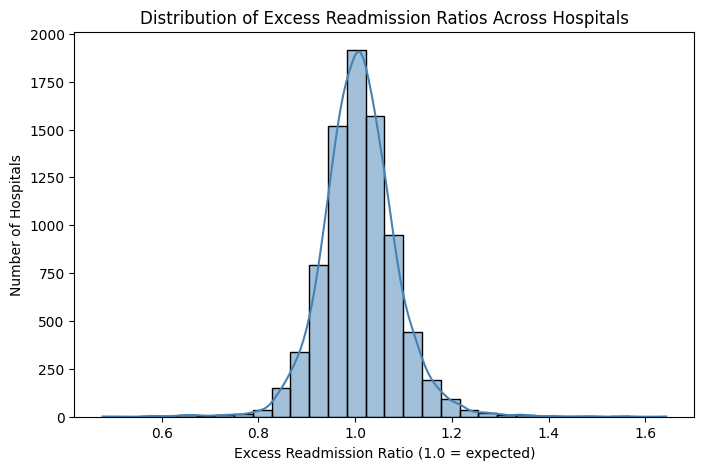

In [4]:
plt.figure(figsize=(8,5))
sns.histplot(df['Excess Readmission Ratio'], bins=30, kde=True, color='steelblue')
plt.title('Distribution of Excess Readmission Ratios Across Hospitals')
plt.xlabel('Excess Readmission Ratio (1.0 = expected)')
plt.ylabel('Number of Hospitals')
plt.show()

**Observation:**  
The distribution of excess readmission ratios is approximately normal, centered around 1.0, meaning most hospitals perform close to the national benchmark.  
Ratios above 1.0 indicate higher-than-expected readmissions, while those below 1.0 suggest better-than-expected outcomes.  
This spread highlights performance variability across hospitals, with a few notable outliers on both ends.

### 3. Predicted vs Expected Readmission Rates

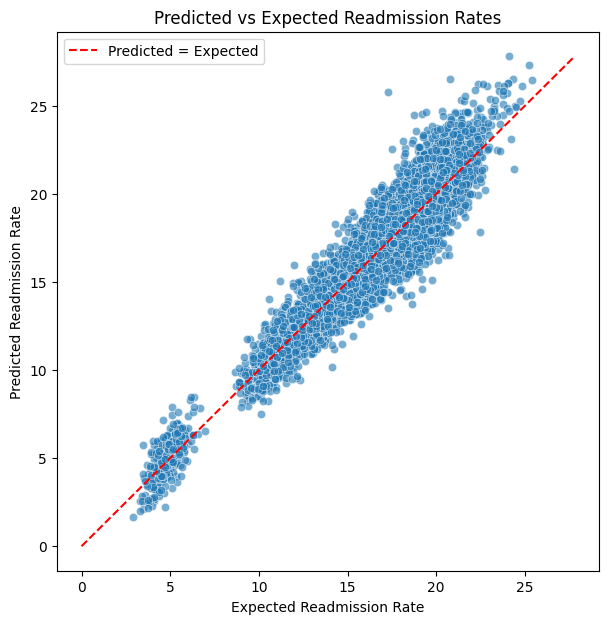

In [5]:
plt.figure(figsize=(7,7))
sns.scatterplot(
    x='Expected Readmission Rate',
    y='Predicted Readmission Rate',
    data=df,
    alpha=0.6
)
max_val = max(df['Expected Readmission Rate'].max(), df['Predicted Readmission Rate'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Predicted = Expected')
plt.title('Predicted vs Expected Readmission Rates')
plt.legend()
plt.show()

**Observation:**  
Predicted and expected readmission rates show a strong linear relationship, clustering tightly around the **red dotted** reference line.  
This suggests that the model’s predicted values closely align with expectations, which indicates consistency in the underlying estimation approach.  
A few deviations above the line indicate hospitals where actual predictions exceed expected performance.

### 4. Variation by Condition

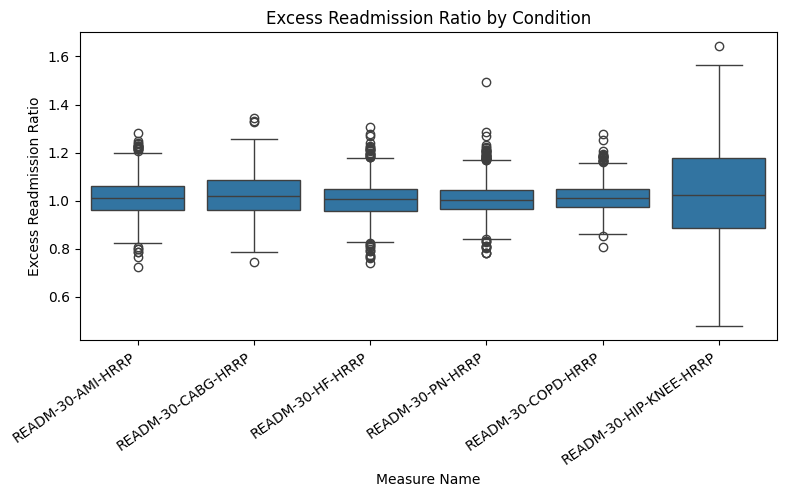

In [6]:
plt.figure(figsize=(9,4))
sns.boxplot(data=df, x='Measure Name', y='Excess Readmission Ratio')
plt.xticks(rotation=35, ha='right')
plt.title('Excess Readmission Ratio by Condition')
plt.show()

**Observation:**  
Most conditions exhibit median excess readmission ratios near 1.0, indicating relatively consistent performance across hospital programs.  
However, the hip and knee replacement category shows a wider interquartile range and more outliers, suggesting greater variability in outcomes for surgical procedures compared to medical conditions.

### 5. Average Excess Readmission Ratio by State (Bar Chart)

In [7]:
# Creting Average Excess Readmission Ratio by State for future use
avg_ratio_by_state = (
    df.groupby("State")["Excess Readmission Ratio"]
    .mean()
    .sort_values(ascending=False)
)

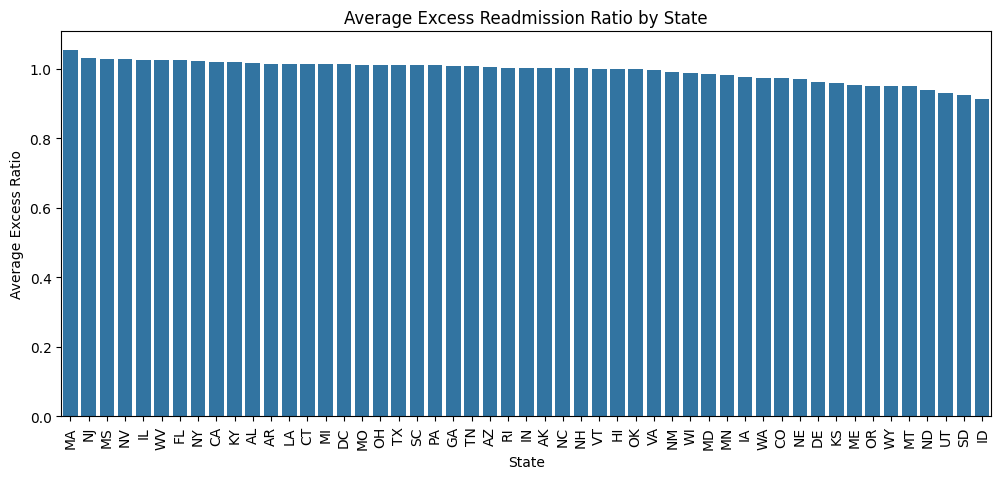

In [8]:
plt.figure(figsize=(12,5))
sns.barplot(x=avg_ratio_by_state.index, y=avg_ratio_by_state.values)
plt.xticks(rotation=90)
plt.ylabel('Average Excess Ratio')
plt.title('Average Excess Readmission Ratio by State')
plt.show()

**Observation:**  
State-level averages reveal modest but notable regional variation in hospital readmission performance.  
Massachusetts, New Jersey, and Illinois report slightly higher average excess ratios, while states like Idaho and South Dakota perform closer to or below expectations.  
This geographic spread may reflect differences in healthcare infrastructure, patient demographics, or policy initiatives.

### 6. Average Hospital Excess Readmission Ratio by State (Choropleth Map)

In [9]:
import plotly.express as px

fig = px.choropleth(
    avg_ratio_by_state.reset_index(),
    locations='State',
    locationmode='USA-states',
    color='Excess Readmission Ratio',
    color_continuous_scale='Reds',
    range_color=(0.95, 1.05),
    scope="usa",
    title="Average Hospital Excess Readmission Ratio by State"
)
fig.show()

**Observation:**  
The choropleth map reinforces regional disparities, with the Northeast and parts of the South showing relatively higher readmission ratios.  
Western and Mountain states generally perform better, with ratios closer to or below the national average.  
These regional differences provide potential avenues for policy analysis or healthcare quality improvement.